In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u

In [2]:
from scipy import integrate

In [3]:
def DM(z,H0,Om,w0,w1):
    c=299792.
   # quad only accepts scalars, so need to use a list comprehension to run through the whole array of zs
    Ezz = lambda zz: 1e6*(c*(1+zz)/H0)*np.sqrt((Om*(1+zz)**3.)+((1-Om)*(1+zz)**(3.*(1.+w0+w1))*np.exp((-3.*w1*zz)/(1+zz))))
    DT=[integrate.quadrature(Ezz, 0, zi) for zi in z]
    # Returns a list, so we convert to a numpy array
    DL=np.array(DT)
    mag=5*np.log10(DL[:,0]/10)
    return mag

In [4]:
zs= np.linspace(0.01, 5., num=1000)

In [5]:
#From Planck observations for CPL mode
O_m=0.3029
w_0=-0.9414
w_1=-0.4303
H0=68.5265

In [6]:
#print DM(zs,70.,0.2855,-1.17,0.35)

In [32]:
mm=DM(zs,H0,O_m,w_0,w_1)

In [33]:
print mm

[33.2212435  34.10917049 34.74168773 35.23419708 35.63812604 35.98091527
 36.27894748 36.54279128 36.77966362 36.9947125  37.19173928 37.37363095
 37.54263172 37.70052076 37.84873243 37.98843997 38.12061534 38.24607271
 38.36550094 38.47948801 38.58853982 38.69309477 38.79353532 38.89019703
 38.98337603 39.0733349  39.16030756 39.24450334 39.32611026 39.40529786
 39.48221954 39.55701454 39.62980963 39.70072056 39.76985332 39.83730519
 39.90316564 39.96751722 40.03043618 40.09199314 40.15225362 40.21127851
 40.26912451 40.32584451 40.3814879  40.4361009  40.4897268  40.54240623
 40.59417735 40.64507605 40.69513616 40.74438955 40.79286631 40.84059488
 40.88760218 40.93391368 40.97955352 41.02454463 41.06890875 41.11266659
 41.1558378  41.19844112 41.2404944  41.28201465 41.32301813 41.36352032
 41.40353606 41.44307951 41.48216424 41.52080322 41.5590089  41.59679321
 41.63416757 41.67114298 41.70772996 41.74393866 41.7797788  41.81525975
 41.85039053 41.88517982 41.91963595 41.953767   41

In [34]:
e = np.random.normal(0., 0.3, 1000)

In [35]:
dist_mod=mm + e

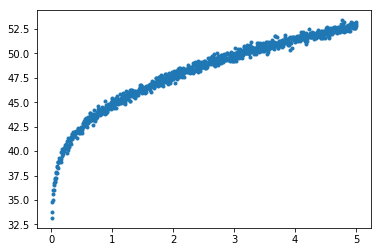

In [36]:
plt.plot(zs,dist_mod, '.')

In [37]:
d = {'redshift': zs, 'distance_mod': dist_mod,'DM_err':e}

In [38]:
df = pd.DataFrame(data=d)

In [39]:
dat=np.sort(df.T, axis=0)
zz = df.redshift
dm = df.distance_mod
edm =df.DM_err

In [40]:
from astropy.cosmology import w0waCDM

In [41]:
def DM1(z,H0,Om,Ode,w0,wa):
    cosmo = w0waCDM(H0=H0* u.km / u.s / u.Mpc, Om0=Om,Ode0=Ode,w0=w0,wa=wa)
    DL=cosmo.luminosity_distance(z)
    mag1=5*np.log10((DL/(10*u.pc)).decompose())
    return mag1

In [42]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0.,2.),('H0',70.0,True,50.,100.),('Ode',0.7,True,0.,2.),('w0',-1.0,True,-2.,2.),('wa',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (DM1(zz,v['H0'],v['Om'],v['Ode'],v['w0'],v['wa'])-dm)/edm

In [43]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [44]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 662
    # data points      = 207
    # variables        = 5
    chi-square         = 282.667911
    reduced chi-square = 1.39934610
    Akaike info crit   = 74.4916692
    Bayesian info crit = 91.1552632
[[Variables]]
    Om:   0.03061466 (init = 0.3)
    H0:   71.6476783 (init = 70)
    Ode:  1.69899185 (init = 0.7)
    w0:  -0.72100679 (init = -1)
    wa:  -0.16911344 (init = -0.1)


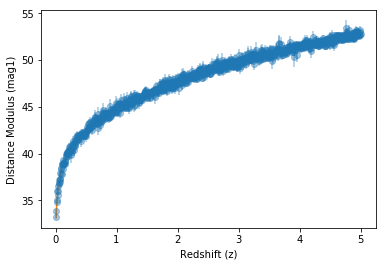

In [45]:
s = (zz.sort_values()).index
plt.errorbar(zz[s],dm[s],yerr=edm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOde= mi.params.valuesdict()['Ode']
bestw0 = mi.params.valuesdict()['w0']
bestwa = mi.params.valuesdict()['wa']
plt.plot(zz[s],DM1(zz[s],bestH0,bestOm,bestOde,bestw0,bestwa))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag1)')
lmfit.report_fit(mi)

In [46]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=p, is_weighted=True)

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [47]:
import corner

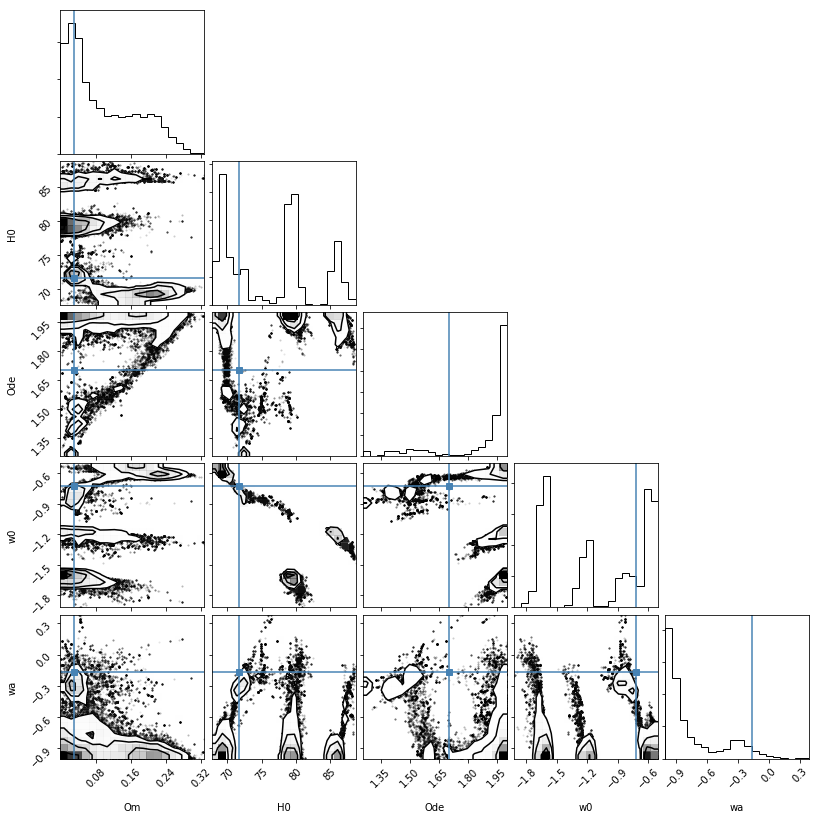

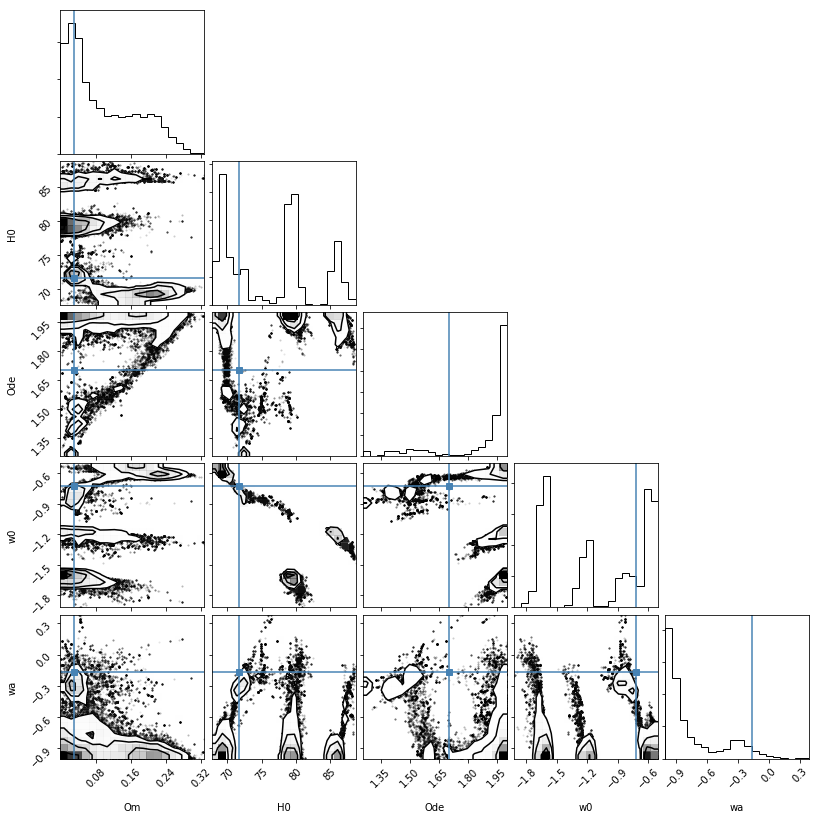

In [48]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))